In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import argrelextrema

In [11]:
def median_scinot_corrections(median, parname):
    '''
    Multiplies parameters in the EXOFASTv2 median table by the scientific notation exponent.

    median: pandas DataFrame for median table
    param: input parameter name
    '''

    scinot = median.scinot[median.parname==parname].iloc[0]

    if type(scinot) == str:
        exp_search = re.findall(r'\\times 10\^{(.*)}', scinot)
        exponent = int(exp_search[0])
    else:
        exponent = 0

    param = median.median_value[median.parname==parname].iloc[0]
    param_corrected = param * 10**exponent

    uperr = median.upper_errorbar[median.parname==parname].iloc[0]
    uperr_corrected = uperr * 10**exponent

    lowerr = median.lower_errorbar[median.parname==parname].iloc[0]
    lowerr_corrected = lowerr * 10**exponent
    return param_corrected, uperr_corrected, lowerr_corrected

def remake_pdf_grazing(target, path, prefix = '', kde_spacing = 1000, save = False, plot_median_stdev = True, median_file_dir = None):
    '''
    Remakes the posterior distribution for the given target that is a grazing transit.

    Parameters
    -----------
    target: The target's identifier, as named in the EXOFASTv2 files
    path: a string containing the path to the input files
    prefix: a string containing the prefix that the EXOFASTv2 output files have, following the object name. Ex: '.MIST.SED.'
    kde_spacing: the spacing/resolution to use when generating the KDEs
    save: boolean for whether or not to save the plot in the current directory
    plot_median_stdev: boolean for whether or not to plot the median value and create a shaded region for the standard deviation
    median_file_dir: a string containing the path to the directory containing the median file for the target
    '''
    
    columns = ['rp', 'mp']
    pdfs = pd.read_csv(path + prefix + '.mcmc.txt', sep='\s+', comment='#', names=columns)

    # Using KDE to generate plots
    kde = stats.gaussian_kde(pdfs.rp) # creating kernels

    x = np.linspace(min(pdfs.rp), max(pdfs.rp), kde_spacing) # generating x values for the KDEs

    y = kde.evaluate(x)

    integral = np.trapz(y, x) # normalizing
    y_normal = y / integral

    # finding extrema

    argmax = np.argmax(y)

    # Plotting
    fig, ax = plt.subplots(ncols=1, nrows=1)
    fig.set_figheight(8)
    fig.set_figwidth(10)

    #ax.set_title(target, fontsize=20, fontweight='bold')
    ax.plot(x, y_normal, lw = 3, c='k')


    ax.axvline(x[argmax], c = 'k', linestyle='--', lw=3)
    ax.text(x[argmax] - 0.2, 0.5, str(round(x[argmax], 2)) + r' R$_{\text{J}}$', c='k', fontsize=18, fontweight='bold')

    if plot_median_stdev == True:
        median_names= ['parname', 'median_value', 'upper_error', 'lower_error']
        medians = pd.read_csv(median_file_dir + prefix + '.median.csv', names=median_names, header=None, skiprows=1)
        rp_median = medians.median_value[medians.parname == 'rp_0'].iloc[0]
        rp_uperror = medians.upper_error[medians.parname == 'rp_0'].iloc[0]
        rp_lowerror = medians.lower_error[medians.parname == 'rp_0'].iloc[0]

        # ax.errorbar(rp_median, 0.7, xerr=[[rp_lowerror], [rp_uperror]], fmt='ro', capsize=3)
        ax.axvline(rp_median, c='darkcyan', linestyle='--', lw=3, zorder=10)
        
        # creating shaded regions for the 68% confidence regions
        ax.fill_betweenx(np.linspace(0, 1, 3), rp_median - rp_lowerror, rp_median + rp_uperror, color='darkcyan', alpha=0.2, zorder=1)

    ax.set_xlim(0.9, 2.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel(r'R$_{\text{P}}$ [R$_{\text{J}}$]', fontsize = 20)
    ax.set_ylabel('Probability Density', fontsize = 20)

    ax.tick_params(which = 'both', direction = 'inout', top=True, right=True)
    ax.tick_params(labelsize = 20, length = 10, width=2)
    ax.tick_params(which = 'minor', length = 7, width = 1)

    plt.tight_layout(pad=1.5, h_pad=1)
    if save == True:
        plt.savefig(f'pdf_{target}_grazing.pdf', bbox_inches='tight', facecolor='white', transparent=False)

def remake_pdf_bimodality(target, path, prefix = '', kde_spacing = 1000, save = False, print_probabilities = False, plot_posterior_modes = False, 
                          plot_median_stdev = True, median_file_dir = None):
    '''
    Remakes the posterior distribution for the given target that is bimodal in stellar mass and age. BEFORE RUNNING THIS, RUN THIS IN IDL:
    remake_corner, '257060897.mcmc.idl', TAGS=['mstar', 'age'], POSTERIORS=[1]
    with the filename changed for the correct target.

    Parameters
    -----------
    target: a string containing the target's identifier
    path: a string containing the path to the input files
    prefix: a string containing the prefix that the EXOFASTv2 output files have. Ex: '257060897'
    kde_spacing: the spacing/resolution to use when generating the KDEs
    save: boolean for whether or not to save the plot in the current directory
    print_probabilities: boolean for whether or not to print the probabilities of each solution
    plot_posterior_modes: boolean for whether or not to plot each posterior mode
    plot_median_stdev: boolean for whether or not to plot the median value and create a shaded region for the standard deviation
    median_file_dir: a string containing the path to the directory containing the median file for the target
    '''
    
    columns = ['mstar', 'age']
    pdfs = pd.read_csv(path + prefix + '.mcmc.txt', sep='\s+', comment='#', names=columns)

    # Using KDE to generate plots
    kde_mstar = stats.gaussian_kde(pdfs.mstar) # creating kernels
    kde_age = stats.gaussian_kde(pdfs.age)

    x_mstar = np.linspace(min(pdfs.mstar), max(pdfs.mstar), kde_spacing) # generating x values for the KDEs
    x_age = np.linspace(min(pdfs.age), max(pdfs.age), kde_spacing)

    y_mstar = kde_mstar.evaluate(x_mstar) # generating y values for the KDEs
    y_age = kde_age.evaluate(x_age)

    integral_mstar = np.trapz(y_mstar, x_mstar) # normalizing
    integral_age = np.trapz(y_age, x_age)
    y_mstar_normal = y_mstar / integral_mstar
    y_age_normal = y_age / integral_age

    # finding extrema

    arg_localmax_mstar = argrelextrema(y_mstar, np.greater, order=int(kde_spacing/20))[0]
    arg_localmax_age = argrelextrema(y_age, np.greater, order=int(kde_spacing/20))[0]

    # Plotting
    fig, axs = plt.subplots(ncols=1, nrows=2)
    fig.set_figheight(14)
    fig.set_figwidth(8)

    ax1 = axs[0]
    ax1.set_title(target, fontsize=20, fontweight='bold')
    ax1.plot(x_mstar, y_mstar_normal, lw = 3, c='k', zorder=2)

    if plot_posterior_modes == True:
        vline_count = 0
        for i in arg_localmax_mstar:
            ax1.axvline(x_mstar[i], c = 'r', linestyle='--', lw=2)
            if vline_count % 2 == 0:
                ax1.text(x_mstar[i] - 0.1, 0, f'{round(x_mstar[i], 2)} M$_\odot$', c='red', fontsize=14, fontweight='bold')
            else:
                ax1.text(x_mstar[i] + 0.01, 0, f'{round(x_mstar[i], 2)} M$_\odot$', c='red', fontsize=14, fontweight='bold')
            vline_count += 1


    ax1.set_xlabel('M$_\star$ [M$_\odot$]', fontsize = 20)
    ax1.set_ylabel('Probability Density', fontsize = 20)

    ax1.tick_params(which = 'both', direction = 'inout', top=True, right=True)
    ax1.tick_params(labelsize = 20, length = 10, width=2)
    ax1.tick_params(which = 'minor', length = 7, width = 1)

    ax2 = axs[1]
    ax2.plot(x_age, y_age_normal, lw=3, c='k', zorder=2)

    if plot_posterior_modes == True:
        vline_count = 0
        for i in arg_localmax_age:
            ax2.axvline(x_age[i], c = 'r', linestyle='--', lw=2)
            if vline_count % 2 == 0:
                ax2.text(x_age[i] - 2.25, 0, f'{round(x_age[i], 2)} Gyr', c='red', fontsize=14, fontweight='bold')
            else:
                ax2.text(x_age[i] + 0.1, 0, f'{round(x_age[i], 2)} Gyr', c='red', fontsize=14, fontweight='bold')
            vline_count += 1
    
    if plot_median_stdev == True:
        median_names= ['parname', 'median_value', 'upper_errorbar', 'lower_errorbar', 'scinot']
        medians = pd.read_csv(median_file_dir + prefix + '.median.csv', names=median_names, header=None, skiprows=1)
        mstar_median, mstar_uperror, mstar_lowerror = median_scinot_corrections(medians, 'mstar_0')

        age_median, age_uperror, age_lowerror = median_scinot_corrections(medians, 'age_0')

        # plotting the medians
        ax1.axvline(mstar_median, c='darkcyan', linestyle='--', lw=3, zorder=10)
        ax2.axvline(age_median, c='darkcyan', linestyle='--', lw=3, zorder=10)

        # obtaining automatically set y-limits to make shaded regions
        ax1_ylim = ax1.get_ylim()
        ax2_ylim = ax2.get_ylim()

        # creating shaded regions for the 68% confidence regions
        ax1.fill_betweenx(np.linspace(ax1_ylim[0], ax1_ylim[1], 3), mstar_median - mstar_lowerror, mstar_median + mstar_uperror, color='darkcyan', alpha=0.2, zorder=1)
        ax2.fill_betweenx(np.linspace(ax2_ylim[0], ax2_ylim[1], 3), age_median - age_lowerror, age_median + age_uperror, color='darkcyan', alpha=0.2, zorder=1)

    ax2.set_xlabel('Age [Gyr]', fontsize = 20)
    ax2.set_ylabel('Probability Density', fontsize = 20)

    ax2.tick_params(which = 'both', direction = 'inout', top=True, right=True)
    ax2.tick_params(labelsize = 20, length = 10, width=2)
    ax2.tick_params(which = 'minor', length = 7, width = 1)

    # resetting y limits on both plots after creating shaded regions to ensure shaded regions cover the entire y-axis
    ax1.set_ylim(ax1_ylim)
    ax2.set_ylim(ax2_ylim)

    # Computing probabilities of each solution
    if print_probabilities == True:
        peak1_mstar = y_mstar_normal[arg_localmax_mstar[0]]
        peak2_mstar = y_mstar_normal[arg_localmax_mstar[1]]
        peaksum_mstar = sum([peak1_mstar, peak2_mstar])
        mstar_prob_spread = [round(peak1_mstar/peaksum_mstar * 100, 2), round(peak2_mstar/peaksum_mstar * 100, 2)]
        print(f'Probability of first and second solution in Mstar: {mstar_prob_spread}%')

        peak1_age = y_mstar_normal[arg_localmax_age[0]]
        peak2_age = y_mstar_normal[arg_localmax_age[1]]
        peaksum_age = sum([peak1_age, peak2_age])
        age_prob_spread = [round(peak1_age/peaksum_age * 100, 2), round(peak2_age/peaksum_age * 100, 2)]
        print(f'Probability of first and second solution in age: {age_prob_spread}%')

        # print the separation in mass between the two solutions
        arg_localmin_mstar = argrelextrema(y_mstar, np.less, order=int(kde_spacing/20))[0]
        print(f'Mass Separation: {x_mstar[arg_localmin_mstar]}')


    plt.tight_layout(pad=1.5, h_pad=1)
    if save == True:
        plt.savefig(f'pdf_{target}_bimodal.pdf', bbox_inches='tight', facecolor='white', transparent=False)

Probability of first and second solution in Mstar: [80.54, 19.46]%
Probability of first and second solution in age: [14.84, 85.16]%
Mass Separation: [1.27699477 1.54861055]


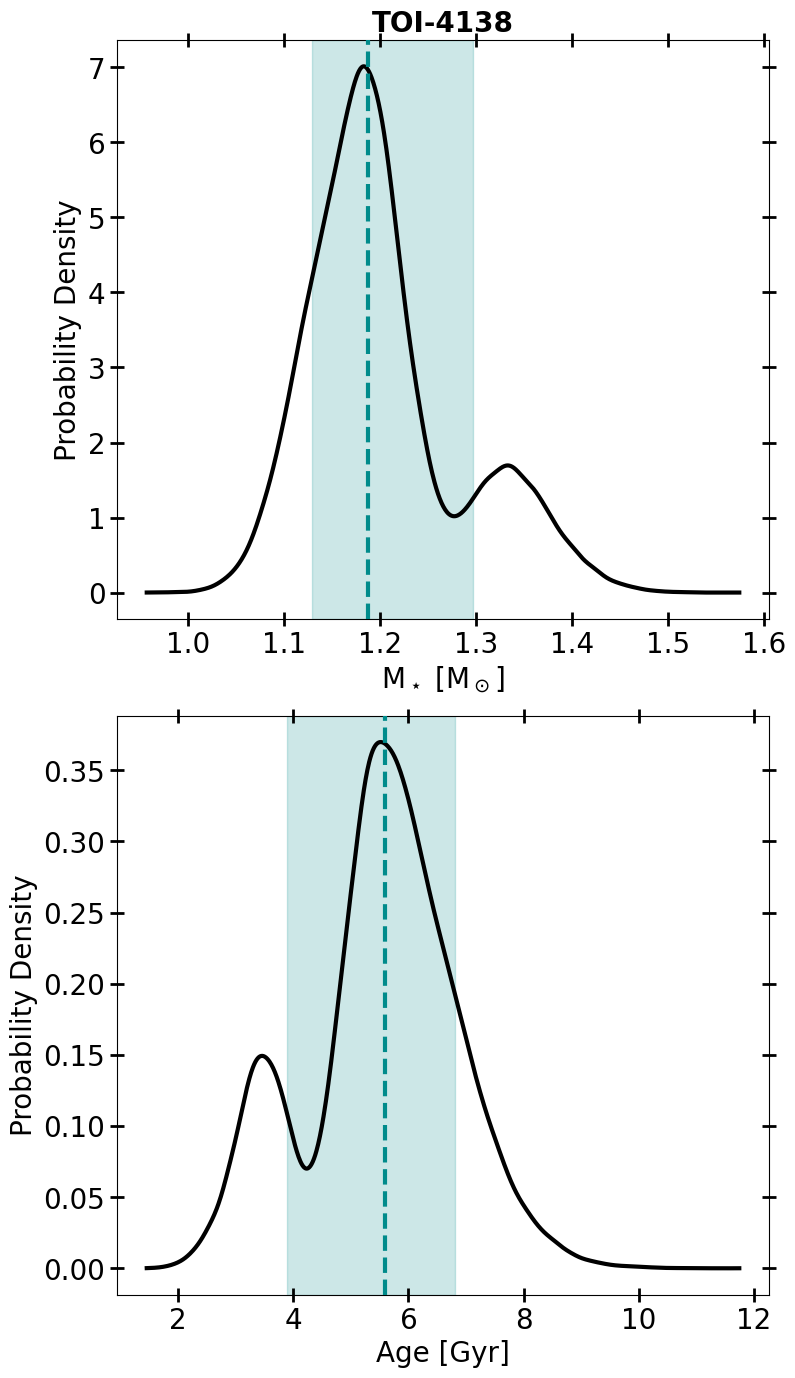

In [23]:
path = '/Users/jack/Research/pipelines/system_figure_pipeline/meep2_data/bimodalities/'
median_file_dir = '/Users/jack/Research/pipelines/system_figure_pipeline/meep2_data/'
remake_pdf_bimodality('TOI-4138', path, save=True, median_file_dir=median_file_dir, prefix='257060897', print_probabilities=True, kde_spacing=1000)

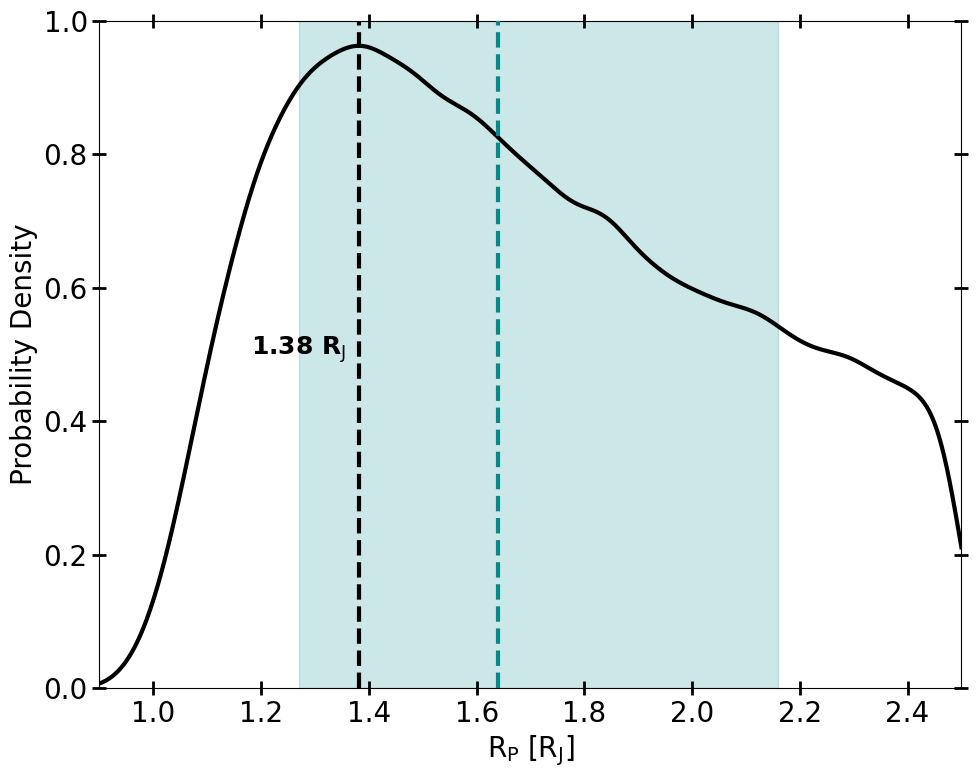

In [7]:
path = '/Users/jack/Research/pipelines/system_figure_pipeline/data/grazing_transit/'
median_file_dir = '/Users/jack/Research/pipelines/system_figure_pipeline/data/'
remake_pdf_grazing('TOI-1855', path, save=True, median_file_dir=median_file_dir, prefix='.MIST.SED')